# Preparing training data

In [1]:
# -- import packages -- 
from pathlib import Path
import numpy as np
import xgboost as xgb
import json
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pandas as pd
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.svm import SVR

In [2]:
training_data_file_name = 'all_record_2.json'
training_data_file_path = Path().absolute().parent / 'training_data' / training_data_file_name

with open(training_data_file_path, 'r', encoding='utf-8') as f:
    training_data: dict = json.load(f)

# keys = [ int(key) for key in training_data.keys()]
# values = list(training_data.values())
X, y = (np.array(training_data.get('request_number')).reshape(-1, 1), np.array(training_data.get('real_process_time')))

In [3]:
# training_data_file_name = 'data.json'
# training_data_file_path = Path().absolute().parent / 'training_data' / training_data_file_name

# with open(training_data_file_path, 'r', encoding='utf-8') as f:
#     training_data = json.load(f)

# # X, y = np.array(training_data.get('request_number')).reshape(-1, 1), np.array([training_data.get('user_cpu_time')[i] + training_data.get('system_cpu_time')[i] for i in range(len(training_data.get('user_cpu_time')))])
# X, y = (np.array(training_data.get('request_number'))).reshape(-1, 1), np.array(training_data.get('real_processing_time'))

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.2, random_state=28
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=30
)

In [4]:
results = []

# Xgboost

In [5]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dval   = xgb.DMatrix(X_val,   label=y_val)
dtest  = xgb.DMatrix(X_test,  label=y_test)

# Create XGBoost regression model
xgb_model = XGBRegressor(
    objective="reg:squarederror",
    n_estimators=50,   # 基础学习器（树）的数量
    max_depth=5,        # 树的最大深度
    colsample_bytree=0.8,   # 随机选择特征的比例
    random_state=12,     # 保持结果可复现
)

xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred_xgb)
mea = mean_absolute_error(y_test, y_pred_xgb)
test_mea = np.mean(y_test)

print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mea}")
print(f"Mean Test Data: {test_mea}")

Mean Squared Error: 0.0011898601726753112
Mean Absolute Error: 0.025974448612821152
Mean Test Data: 5.103079204958988


In [6]:
for name, model, predict_val, predict_test in [
    ("XGBoost", xgb_model, xgb_model.predict(X_val), xgb_model.predict(X_test))
]:
    results.append({
        "Model": name,
        "Val MSE": mean_squared_error(y_val, predict_val),
        "Val MAE": mean_absolute_error(y_val, predict_val),
        "Val R2": r2_score(y_val, predict_val),
        "Test MSE": mean_squared_error(y_test, predict_test),
        "Test MAE": mean_absolute_error(y_test, predict_test),
        "Test R2": r2_score(y_test, predict_test)
    })

# Import Packages

In [7]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score

# Other Model
- Linear Regression
- Support Vector Regression
- Lasso Regression
- Ridge Regression

In [8]:
model_list = [
    ("Linear Regression", LinearRegression()),
    ("Support Vector Regression", SVR(kernel='rbf')),
    ("Lasso Regression", Lasso(alpha=0.3)),
    ("Ridge Regression", Ridge(alpha=0.5)),
]

- Fit

In [9]:
for name, model in model_list:
    model.fit(X_train, y_train)
    predict_val = model.predict(X_val)
    predict_test = model.predict(X_test)

    results.append({
        "Model": name,
        "Val MSE": mean_squared_error(y_val, predict_val),
        "Val MAE": mean_absolute_error(y_val, predict_val),
        "Val R2": r2_score(y_val, predict_val),
        "Test MSE": mean_squared_error(y_test, predict_test),
        "Test MAE": mean_absolute_error(y_test, predict_test),
        "Test R2": r2_score(y_test, predict_test)
    })

# Print Data

In [10]:
results_df = pd.DataFrame(results)
print(results_df)

                       Model   Val MSE   Val MAE    Val R2  Test MSE  \
0                    XGBoost  0.001142  0.026167  0.999920  0.001190   
1          Linear Regression  0.268460  0.447393  0.981304  0.243800   
2  Support Vector Regression  0.002389  0.040930  0.999834  0.002457   
3           Lasso Regression  0.268460  0.447393  0.981304  0.243800   
4           Ridge Regression  0.268460  0.447393  0.981304  0.243800   

   Test MAE   Test R2  
0  0.025974  0.999914  
1  0.420016  0.982427  
2  0.042024  0.999823  
3  0.420016  0.982427  
4  0.420016  0.982427  


# Save Result

In [11]:
results_df.to_csv('../../model_results_2.csv', index=False)
print("保存完成：model_results_2.csv")

保存完成：model_results_2.csv


# Show in Fig

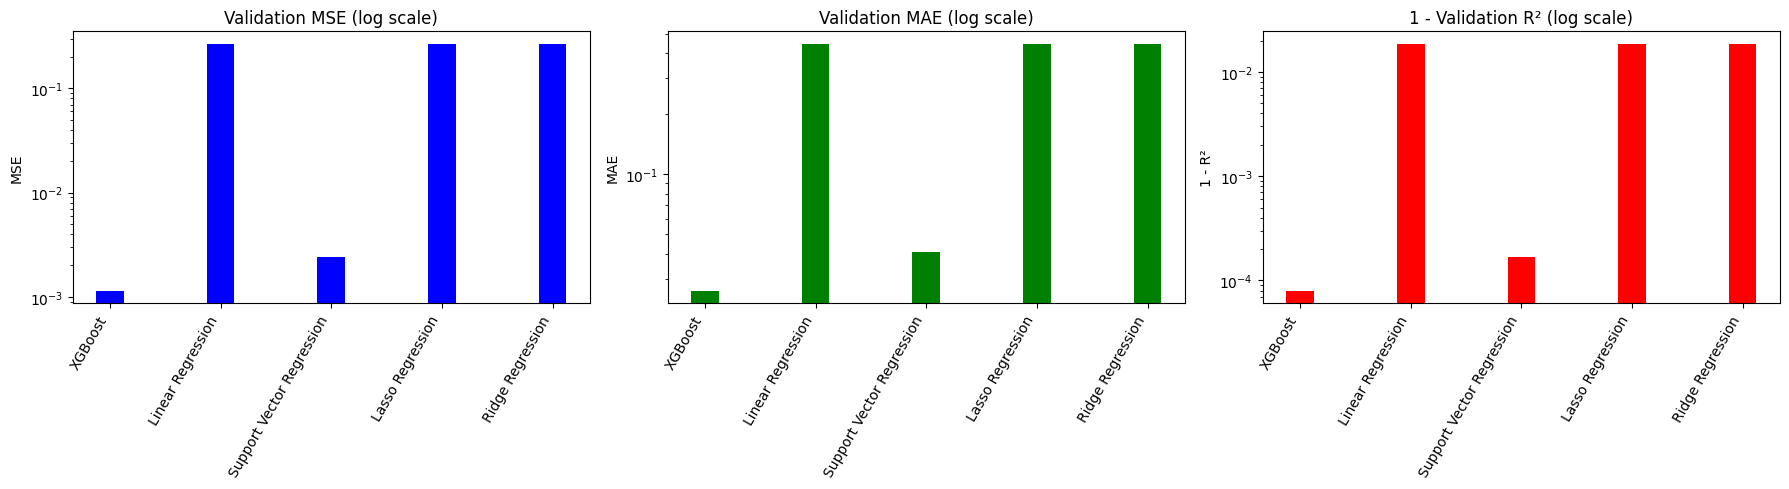

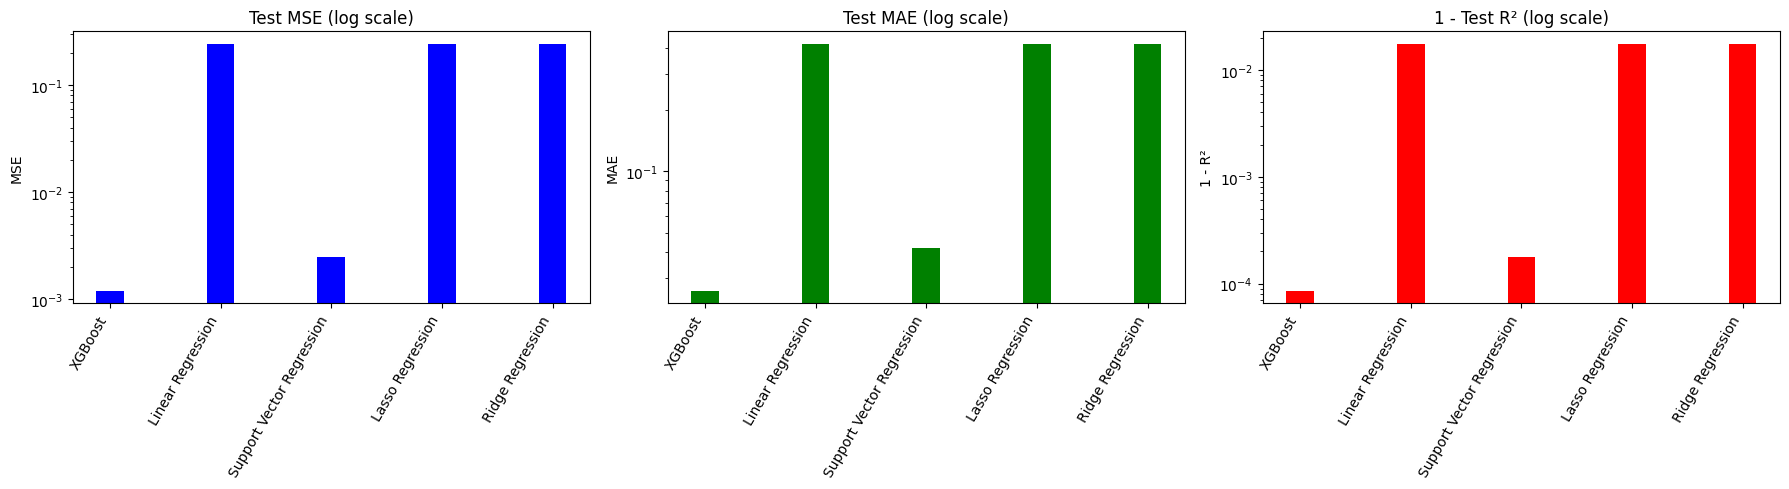

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path

# Load evaluation results
results_df = pd.read_csv(Path('../../model_results_2.csv'))
models = results_df['Model'].tolist()

# Prepare Validation metrics
val_mse = results_df['Val MSE'].tolist()
val_mae = results_df['Val MAE'].tolist()
val_r2 = results_df['Val R2'].tolist()
val_r2_residuals = [(1 - val) for val in val_r2]

# Prepare Test metrics
test_mse = results_df['Test MSE'].tolist()
test_mae = results_df['Test MAE'].tolist()
test_r2 = results_df['Test R2'].tolist()
test_r2_residuals = [(1 - val) for val in test_r2]

# Model index
x = np.arange(len(models))
width = 0.25

# Validation Set Plot
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

axs[0].bar(x, val_mse, width, color='blue')
axs[0].set_yscale('log')
axs[0].set_title("Validation MSE (log scale)")
axs[0].set_xticks(x)
axs[0].set_xticklabels(models, rotation=60, ha='right')
axs[0].set_ylabel('MSE')

axs[1].bar(x, val_mae, width, color='green')
axs[1].set_yscale('log')
axs[1].set_title("Validation MAE (log scale)")
axs[1].set_xticks(x)
axs[1].set_xticklabels(models, rotation=60, ha='right')
axs[1].set_ylabel('MAE')

axs[2].bar(x, val_r2_residuals, width, color='red')
axs[2].set_yscale('log')
axs[2].set_title("1 - Validation R² (log scale)")
axs[2].set_xticks(x)
axs[2].set_xticklabels(models, rotation=60, ha='right')
axs[2].set_ylabel('1 - R²')

plt.tight_layout()
plt.show()

# Test Set Plot
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

axs[0].bar(x, test_mse, width, color='blue')
axs[0].set_yscale('log')
axs[0].set_title("Test MSE (log scale)")
axs[0].set_xticks(x)
axs[0].set_xticklabels(models, rotation=60, ha='right')
axs[0].set_ylabel('MSE')

axs[1].bar(x, test_mae, width, color='green')
axs[1].set_yscale('log')
axs[1].set_title("Test MAE (log scale)")
axs[1].set_xticks(x)
axs[1].set_xticklabels(models, rotation=60, ha='right')
axs[1].set_ylabel('MAE')

axs[2].bar(x, test_r2_residuals, width, color='red')
axs[2].set_yscale('log')
axs[2].set_title("1 - Test R² (log scale)")
axs[2].set_xticks(x)
axs[2].set_xticklabels(models, rotation=60, ha='right')
axs[2].set_ylabel('1 - R²')

plt.tight_layout()
plt.show()


# Save model

In [13]:
# model.save_model(Path() / 'modelsfile' / 'xgboost_newest_model_4.json')